# Arcadian Outfitters - Customer Segmentation & Reorder Visit Optimization

## Objective
Segment customers into actionable groups based on **sales velocity** and **total spend** to determine:
1. **When to visit** each store to place a reorder
2. **How to keep displays at least 50% full** (104+ hats of 208 total)
3. **How to avoid wasting visits** on stores that don't need restocking yet

### Display Economics
| Metric | Value |
|--------|-------|
| Full display capacity | 208 hats |
| Full display cost (wholesale) | $2,469 |
| Cost per hat (wholesale) | $11.87 |
| 50% threshold | 104 hats / ~$1,235 |
| Hats per sleeve | 8 |
| Cost per sleeve | ~$96 |

---
## 1. Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import xml.etree.ElementTree as ET
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:,.2f}'.format)
sns.set_theme(style='whitegrid', palette='deep')

# === CONSTANTS ===
FULL_DISPLAY_HATS = 208
FULL_DISPLAY_COST = 2469.0
COST_PER_HAT = FULL_DISPLAY_COST / FULL_DISPLAY_HATS  # ~$11.87
HALF_DISPLAY_HATS = FULL_DISPLAY_HATS // 2  # 104
HALF_DISPLAY_COST = FULL_DISPLAY_COST / 2  # ~$1,234.50
HATS_PER_SLEEVE = 8
COST_PER_SLEEVE = 96.0

print(f"Display Economics:")
print(f"  Full display: {FULL_DISPLAY_HATS} hats @ ${FULL_DISPLAY_COST:,.2f}")
print(f"  Per hat wholesale: ${COST_PER_HAT:.2f}")
print(f"  50% threshold: {HALF_DISPLAY_HATS} hats @ ${HALF_DISPLAY_COST:,.2f}")
print(f"  Per sleeve: {HATS_PER_SLEEVE} hats @ ${COST_PER_SLEEVE:.2f}")

Display Economics:
  Full display: 208 hats @ $2,469.00
  Per hat wholesale: $11.87
  50% threshold: 104 hats @ $1,234.50
  Per sleeve: 8 hats @ $96.00


In [2]:
# --- Parse NetSuite XML-based XLS files ---
NS = '{urn:schemas-microsoft-com:office:spreadsheet}'

def parse_netsuite_xls(filepath):
    """Parse NetSuite XML-based XLS export into raw row data."""
    tree = ET.parse(filepath)
    root = tree.getroot()
    worksheet = root.findall(f'.//{NS}Worksheet')[0]
    table = worksheet.find(f'{NS}Table')
    rows = table.findall(f'{NS}Row')
    data = []
    for row in rows:
        cells = row.findall(f'{NS}Cell')
        values = []
        for cell in cells:
            data_el = cell.find(f'{NS}Data')
            values.append(data_el.text if data_el is not None else None)
        data.append(values)
    return data

print("Parsing SalesbyCustomerDetail-131.xls (detailed transactions)...")
raw_customer_detail = parse_netsuite_xls('SalesbyCustomerDetail-131.xls')
print(f"  Rows parsed: {len(raw_customer_detail):,}")

print("Parsing CustomSalesbyHistoricalTeamDetail-285.xls (rep assignments)...")
raw_team_detail = parse_netsuite_xls('CustomSalesbyHistoricalTeamDetail-285.xls')
print(f"  Rows parsed: {len(raw_team_detail):,}")

print("Loading SalesOverview CSV (invoice summary)...")
sales_overview = pd.read_csv('SalesOverview_02062026_0211PM_SalesByCustomer.csv')
print(f"  Rows loaded: {len(sales_overview):,}")
print("\nAll data loaded successfully.")

Parsing SalesbyCustomerDetail-131.xls (detailed transactions)...


  Rows parsed: 39,935
Parsing CustomSalesbyHistoricalTeamDetail-285.xls (rep assignments)...


  Rows parsed: 37,757
Loading SalesOverview CSV (invoice summary)...
  Rows loaded: 2,956

All data loaded successfully.


---
## 2. Data Cleaning & Transaction Extraction

In [3]:
# --- Extract structured transactions from the customer detail XLS ---
# This file has a hierarchical layout: customer name as a section header,
# then transaction rows beneath it, then a "Total" row.

transactions = []
current_customer = None

for row in raw_customer_detail[7:]:  # Skip report header rows (0-6)
    if not row:
        continue
    while len(row) < 6:
        row.append(None)
    
    # Customer header row: name in col 0, rest empty
    if row[0] and not row[0].startswith('Total'):
        current_customer = row[0].replace('&amp;', '&')  # Fix HTML encoding
    elif row[0] and row[0].startswith('Total'):
        current_customer = None  # End of customer section
    elif current_customer and row[1]:  # Transaction row
        transactions.append({
            'Customer': current_customer,
            'Transaction_Type': row[1],
            'Date': row[2],
            'Document_Number': row[3],
            'Memo': row[4],
            'Total_Revenue': row[5]
        })

txn_df = pd.DataFrame(transactions)
txn_df['Total_Revenue'] = pd.to_numeric(txn_df['Total_Revenue'], errors='coerce')
txn_df['Date'] = pd.to_datetime(txn_df['Date'], errors='coerce')

# Remove internal/journal entries
txn_df = txn_df[txn_df['Customer'] != '- No Customer/Project -'].copy()

print(f"Total transaction line items: {len(txn_df):,}")
print(f"\nTransaction type breakdown:")
print(txn_df.groupby('Transaction_Type').agg(
    Count=('Total_Revenue', 'count'),
    Total_Revenue=('Total_Revenue', 'sum'),
    Avg_Revenue=('Total_Revenue', 'mean')
).to_string())
print(f"\nDate range: {txn_df['Date'].min().strftime('%Y-%m-%d')} to {txn_df['Date'].max().strftime('%Y-%m-%d')}")
print(f"Unique customers: {txn_df['Customer'].nunique():,}")

Total transaction line items: 37,618

Transaction type breakdown:
                  Count  Total_Revenue  Avg_Revenue
Transaction_Type                                   
Credit Memo        5365    -318,989.85       -59.46
Invoice           32252   2,865,076.38        88.83
Journal               1      -1,176.00    -1,176.00

Date range: 2025-01-01 to 2026-02-06
Unique customers: 1,099


In [4]:
# --- Extract rep-to-customer mapping from team detail XLS ---
rep_transactions = []
current_rep = None

for row in raw_team_detail[7:]:  # Skip header rows
    if not row:
        continue
    while len(row) < 7:
        row.append(None)
    
    if row[0] and not row[0].startswith('Total'):
        current_rep = row[0]
    elif row[0] and row[0].startswith('Total'):
        current_rep = None
    elif current_rep and row[1]:
        customer_name = row[4].replace('&amp;', '&') if row[4] else None
        rep_transactions.append({
            'Sales_Rep': current_rep,
            'Transaction_Type': row[1],
            'Date': row[2],
            'Document_Number': row[3],
            'Customer': customer_name,
            'Total_Revenue': row[5]
        })

rep_df = pd.DataFrame(rep_transactions)
rep_df['Total_Revenue'] = pd.to_numeric(rep_df['Total_Revenue'], errors='coerce')

# Build primary rep mapping: rep with most invoice revenue per customer
rep_invoices = rep_df[rep_df['Transaction_Type'] == 'Invoice'].copy()
rep_map = rep_invoices.groupby(['Customer', 'Sales_Rep'])['Total_Revenue'].sum().reset_index()
rep_map = rep_map.sort_values('Total_Revenue', ascending=False).drop_duplicates('Customer', keep='first')
rep_map = rep_map[['Customer', 'Sales_Rep']].rename(columns={'Sales_Rep': 'Primary_Rep'})

print(f"Rep-customer mappings: {len(rep_map):,}")
print(f"\nReps and their customer counts:")
print(rep_map['Primary_Rep'].value_counts().to_string())

Rep-customer mappings: 1,041

Reps and their customer counts:
Primary_Rep
Lamar Helm                   166
Andy Coon                    165
Bobbi Marshall                90
Merlin Gleed                  68
JADEN BLACK                   67
Elijah Benedick               66
Ann Wheelock                  58
Devin Friebe                  45
Eric Arnold                   45
Jason Black                   45
InHouse Orders                37
Decker Larson                 35
VIEGEAR                       24
Paula Hemmen                  16
Abby Howerton                 14
Allison  Amezcua              13
Natalie  Brydson              13
Joseph Perez                  13
Matthew  Jorgensen             8
Christa VIE                    7
Dale  Becker                   7
- Unassigned -                 6
Jeremiah Wagenman              6
InStore - Andy Coon            6
Riley Hurn                     4
Linnzy Foster                  4
Lori  Moore                    3
Jimmy Latter                   3
Fe

In [5]:
# --- Build invoice-level summary ---
# Each invoice can have multiple line items (different hat styles).
# We aggregate to get total per invoice.

invoices = txn_df[txn_df['Transaction_Type'] == 'Invoice'].copy()
credits = txn_df[txn_df['Transaction_Type'] == 'Credit Memo'].copy()

# Invoice-level totals
invoice_summary = invoices.groupby(['Customer', 'Document_Number', 'Date']).agg(
    Invoice_Revenue=('Total_Revenue', 'sum'),
    Line_Items=('Total_Revenue', 'count')
).reset_index()

# Estimate hats per invoice: revenue / cost_per_hat
invoice_summary['Est_Hats'] = (invoice_summary['Invoice_Revenue'] / COST_PER_HAT).round(0).astype(int)
# Also estimate sleeves
invoice_summary['Est_Sleeves'] = invoice_summary['Line_Items']  # Each line item is typically 1 sleeve

# Credit memo totals per customer
credit_summary = credits.groupby('Customer')['Total_Revenue'].sum().reset_index()
credit_summary.columns = ['Customer', 'Total_Credits']

print(f"Total invoices: {len(invoice_summary):,}")
print(f"\nInvoice revenue distribution:")
print(invoice_summary['Invoice_Revenue'].describe())
print(f"\nEstimated hats per invoice:")
print(invoice_summary['Est_Hats'].describe())
print(f"\nCustomers with credit memos: {len(credit_summary):,}")
print(f"Total credit amount: ${credit_summary['Total_Credits'].sum():,.2f}")

Total invoices: 2,936

Invoice revenue distribution:
count    2,936.00
mean       975.84
std        838.59
min     -5,000.00
25%        384.00
50%        816.60
75%      1,344.00
max     18,720.00
Name: Invoice_Revenue, dtype: float64

Estimated hats per invoice:
count   2,936.00
mean       82.20
std        70.65
min      -421.00
25%        32.00
50%        69.00
75%       113.00
max     1,577.00
Name: Est_Hats, dtype: float64

Customers with credit memos: 503
Total credit amount: $-318,989.85


---
## 3. Customer Profile Construction
Build a comprehensive profile for each customer with metrics needed for segmentation.

In [6]:
# --- Build customer profiles ---
DATA_END_DATE = pd.Timestamp('2026-02-06')  # Date of the latest data extract

customer_profiles = invoice_summary.groupby('Customer').agg(
    Total_Invoice_Revenue=('Invoice_Revenue', 'sum'),
    Num_Orders=('Document_Number', 'nunique'),
    Avg_Order_Value=('Invoice_Revenue', 'mean'),
    Median_Order_Value=('Invoice_Revenue', 'median'),
    Max_Order_Value=('Invoice_Revenue', 'max'),
    Min_Order_Value=('Invoice_Revenue', 'min'),
    Total_Hats_Ordered=('Est_Hats', 'sum'),
    Avg_Hats_Per_Order=('Est_Hats', 'mean'),
    Total_Line_Items=('Line_Items', 'sum'),
    First_Order_Date=('Date', 'min'),
    Last_Order_Date=('Date', 'max'),
).reset_index()

# Merge credit memos
customer_profiles = customer_profiles.merge(credit_summary, on='Customer', how='left')
customer_profiles['Total_Credits'] = customer_profiles['Total_Credits'].fillna(0)
customer_profiles['Net_Revenue'] = customer_profiles['Total_Invoice_Revenue'] + customer_profiles['Total_Credits']  # Credits are negative

# Merge rep mapping
customer_profiles = customer_profiles.merge(rep_map, on='Customer', how='left')
customer_profiles['Primary_Rep'] = customer_profiles['Primary_Rep'].fillna('Unassigned')

# Time-based metrics
customer_profiles['Days_Active'] = (customer_profiles['Last_Order_Date'] - customer_profiles['First_Order_Date']).dt.days
customer_profiles['Days_Since_Last_Order'] = (DATA_END_DATE - customer_profiles['Last_Order_Date']).dt.days
customer_profiles['Account_Age_Days'] = (DATA_END_DATE - customer_profiles['First_Order_Date']).dt.days

# Frequency metrics (only for customers with 2+ orders)
customer_profiles['Avg_Days_Between_Orders'] = customer_profiles.apply(
    lambda r: r['Days_Active'] / (r['Num_Orders'] - 1) if r['Num_Orders'] > 1 else np.nan, axis=1
)

# Velocity metrics
# Monthly revenue run rate (use account age, minimum 30 days to avoid inflating new accounts)
customer_profiles['Months_Active'] = np.maximum(customer_profiles['Account_Age_Days'] / 30.44, 1)
customer_profiles['Monthly_Revenue'] = customer_profiles['Net_Revenue'] / customer_profiles['Months_Active']
customer_profiles['Monthly_Hats'] = customer_profiles['Total_Hats_Ordered'] / customer_profiles['Months_Active']

# Sell-through estimation
# For repeat customers: hats sold between orders estimates sell-through rate
customer_profiles['Daily_Hat_Velocity'] = customer_profiles.apply(
    lambda r: r['Avg_Hats_Per_Order'] / r['Avg_Days_Between_Orders'] 
    if r['Num_Orders'] > 1 and r['Avg_Days_Between_Orders'] > 0 else np.nan, axis=1
)

# Days until 50% display depletion (from full)
customer_profiles['Days_To_50pct'] = customer_profiles['Daily_Hat_Velocity'].apply(
    lambda v: HALF_DISPLAY_HATS / v if pd.notna(v) and v > 0 else np.nan
)

print(f"Customer profiles built: {len(customer_profiles):,}")
print(f"\n{'='*60}")
print(f"KEY PROFILE STATISTICS")
print(f"{'='*60}")
print(f"\nCustomers with repeat orders: {(customer_profiles['Num_Orders'] > 1).sum():,} ({(customer_profiles['Num_Orders'] > 1).mean():.1%})")
print(f"Single-order customers: {(customer_profiles['Num_Orders'] == 1).sum():,} ({(customer_profiles['Num_Orders'] == 1).mean():.1%})")
print(f"\nNet Revenue: ${customer_profiles['Net_Revenue'].sum():,.2f}")
print(f"Average net revenue per customer: ${customer_profiles['Net_Revenue'].mean():,.2f}")
print(f"Median net revenue per customer: ${customer_profiles['Net_Revenue'].median():,.2f}")
print(f"\nAverage days between orders (repeat customers): {customer_profiles['Avg_Days_Between_Orders'].mean():.0f}")
print(f"Median days between orders (repeat customers): {customer_profiles['Avg_Days_Between_Orders'].median():.0f}")

Customer profiles built: 1,041

KEY PROFILE STATISTICS

Customers with repeat orders: 714 (68.6%)
Single-order customers: 327 (31.4%)

Net Revenue: $2,601,900.58
Average net revenue per customer: $2,499.42
Median net revenue per customer: $2,203.50

Average days between orders (repeat customers): 82
Median days between orders (repeat customers): 69


In [7]:
# Preview the profiles
display_cols = ['Customer', 'Primary_Rep', 'Net_Revenue', 'Num_Orders', 'Avg_Order_Value',
                'Total_Hats_Ordered', 'Avg_Days_Between_Orders', 'Monthly_Revenue',
                'Daily_Hat_Velocity', 'Days_To_50pct', 'Days_Since_Last_Order']

print("Top 15 customers by net revenue:")
customer_profiles.nlargest(15, 'Net_Revenue')[display_cols]

Top 15 customers by net revenue:


,Customer,Primary_Rep,Net_Revenue,Num_Orders,Avg_Order_Value,Total_Hats_Ordered,Avg_Days_Between_Orders,Monthly_Revenue,Daily_Hat_Velocity,Days_To_50pct,Days_Since_Last_Order
687,Mike's Market-Garden City,Unassigned,"23,854.50",29,833.79,2035,10.50,"2,349.94",6.68,15.56,15
873,Templeton Feed and Grain,VIEGEAR,"22,508.00",2,"11,254.00",1896,14.00,"10,226.02",67.71,1.54,53
908,Town Pump (Employee Orders),Unassigned,"15,726.00",67,234.72,1323,0.88,"8,253.44",22.47,4.63,0
582,Hoback Market,Lamar Helm,"15,702.00",11,"1,455.27",1349,29.20,"1,546.82",4.20,24.76,17
639,Last Chance C Store - Island Park,Lamar Helm,"14,592.00",8,"1,921.50",1294,33.14,"1,495.56",4.88,21.31,65
801,Riverside Station-West Yellowstone,Unassigned,"11,916.00",6,"2,242.00",1134,37.20,"1,439.38",5.08,20.47,66
936,Town Pump - Glendive - 8320-1205,Unassigned,"11,692.00",7,"1,670.29",986,42.33,"1,358.41",3.33,31.26,8
88,Broulim's Alpine Store,Unassigned,"11,040.00",9,"1,226.67",931,34.25,"1,154.84",3.02,34.43,17
686,Mike's Market Lava,Unassigned,"11,028.00",13,848.31,929,23.08,"1,115.26",3.10,33.59,24
919,Town Pump - Bonner #1 - 8500-1070,Unassigned,"10,884.00",10,"1,088.40",916,32.78,"1,093.43",2.79,37.21,8


---
## 4. Exploratory Data Analysis
Understand the distributions before segmenting.

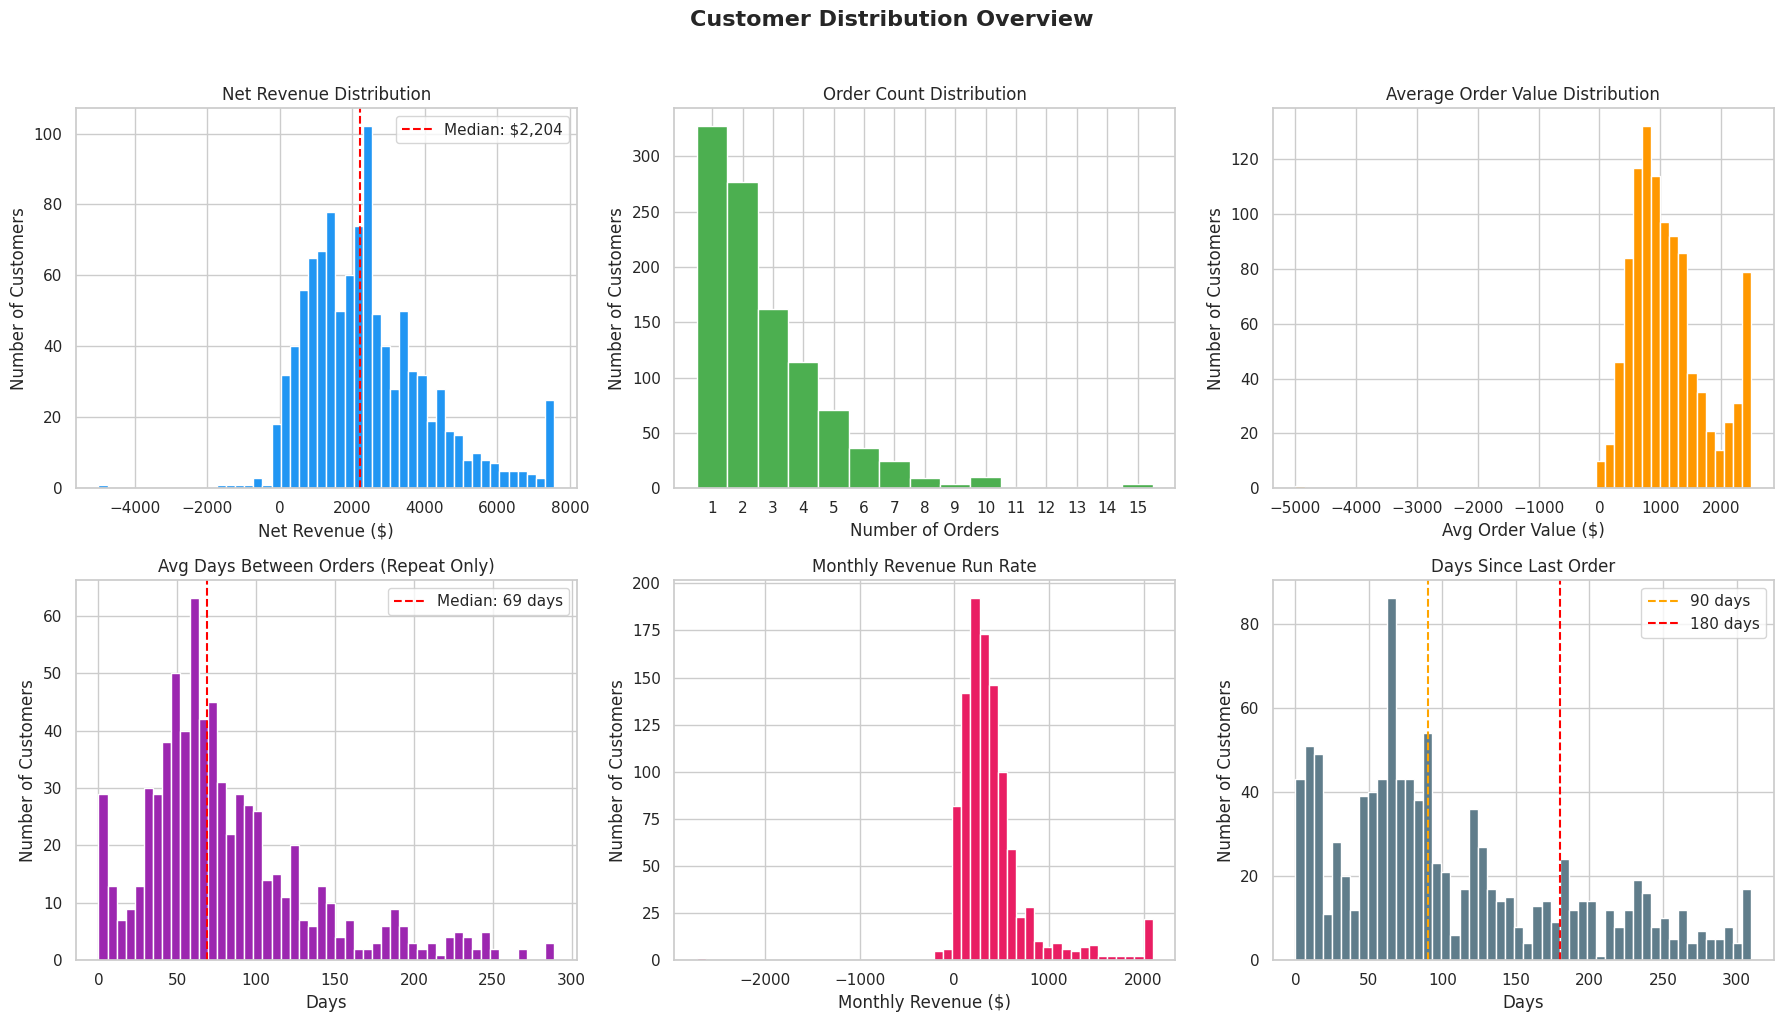

Saved: customer_distributions.png


In [8]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Customer Distribution Overview', fontsize=16, fontweight='bold', y=1.02)

# 1. Net Revenue distribution
ax = axes[0, 0]
customer_profiles['Net_Revenue'].clip(upper=customer_profiles['Net_Revenue'].quantile(0.98)).hist(
    bins=50, ax=ax, color='#2196F3', edgecolor='white')
ax.set_title('Net Revenue Distribution')
ax.set_xlabel('Net Revenue ($)')
ax.set_ylabel('Number of Customers')
ax.axvline(customer_profiles['Net_Revenue'].median(), color='red', linestyle='--', label=f"Median: ${customer_profiles['Net_Revenue'].median():,.0f}")
ax.legend()

# 2. Number of Orders
ax = axes[0, 1]
order_counts = customer_profiles['Num_Orders'].clip(upper=15)
order_counts.hist(bins=range(1, 17), ax=ax, color='#4CAF50', edgecolor='white', align='left')
ax.set_title('Order Count Distribution')
ax.set_xlabel('Number of Orders')
ax.set_ylabel('Number of Customers')
ax.set_xticks(range(1, 16))

# 3. Average Order Value
ax = axes[0, 2]
customer_profiles['Avg_Order_Value'].clip(upper=customer_profiles['Avg_Order_Value'].quantile(0.98)).hist(
    bins=50, ax=ax, color='#FF9800', edgecolor='white')
ax.set_title('Average Order Value Distribution')
ax.set_xlabel('Avg Order Value ($)')
ax.set_ylabel('Number of Customers')

# 4. Days Between Orders (repeat customers only)
ax = axes[1, 0]
repeat = customer_profiles[customer_profiles['Num_Orders'] > 1]
repeat['Avg_Days_Between_Orders'].clip(upper=300).hist(bins=50, ax=ax, color='#9C27B0', edgecolor='white')
ax.set_title('Avg Days Between Orders (Repeat Only)')
ax.set_xlabel('Days')
ax.set_ylabel('Number of Customers')
ax.axvline(repeat['Avg_Days_Between_Orders'].median(), color='red', linestyle='--', 
           label=f"Median: {repeat['Avg_Days_Between_Orders'].median():.0f} days")
ax.legend()

# 5. Monthly Revenue
ax = axes[1, 1]
customer_profiles['Monthly_Revenue'].clip(upper=customer_profiles['Monthly_Revenue'].quantile(0.98)).hist(
    bins=50, ax=ax, color='#E91E63', edgecolor='white')
ax.set_title('Monthly Revenue Run Rate')
ax.set_xlabel('Monthly Revenue ($)')
ax.set_ylabel('Number of Customers')

# 6. Days Since Last Order
ax = axes[1, 2]
customer_profiles['Days_Since_Last_Order'].hist(bins=50, ax=ax, color='#607D8B', edgecolor='white')
ax.set_title('Days Since Last Order')
ax.set_xlabel('Days')
ax.set_ylabel('Number of Customers')
ax.axvline(90, color='orange', linestyle='--', label='90 days')
ax.axvline(180, color='red', linestyle='--', label='180 days')
ax.legend()

plt.tight_layout()
plt.savefig('customer_distributions.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: customer_distributions.png")

In [9]:
# --- Scatter: Order Frequency vs. Average Order Value (repeat customers) ---
repeat = customer_profiles[customer_profiles['Num_Orders'] > 1].copy()

# Plotly size requires positive values; use absolute value of Net_Revenue and filter negatives
repeat_plot = repeat[repeat['Net_Revenue'] > 0].copy()

fig = px.scatter(
    repeat_plot,
    x='Avg_Days_Between_Orders',
    y='Avg_Order_Value',
    size='Net_Revenue',
    color='Primary_Rep',
    hover_name='Customer',
    hover_data={'Net_Revenue': ':$,.0f', 'Num_Orders': True, 'Avg_Days_Between_Orders': ':.0f'},
    title='Order Frequency vs. Average Order Value (Repeat Customers)',
    labels={
        'Avg_Days_Between_Orders': 'Avg Days Between Orders',
        'Avg_Order_Value': 'Avg Order Value ($)',
        'Net_Revenue': 'Net Revenue ($)'
    },
    size_max=30,
    opacity=0.7,
    height=600
)
fig.update_layout(template='plotly_white')
fig.show()

---
## 5. Customer Segmentation (K-Means Clustering)

We segment on three dimensions that directly tie to visit scheduling:
1. **Monthly Revenue** - How much revenue they generate per month
2. **Order Frequency** - How often they reorder (proxy for sell-through rate)
3. **Average Order Value** - How large each reorder is

### Why these features?
- **High monthly revenue + frequent orders** = high-velocity store, needs frequent visits
- **High monthly revenue + infrequent orders** = big orders but slower sell-through
- **Low monthly revenue + infrequent orders** = low-priority store, visit sparingly

In [10]:
# --- Prepare segmentation dataset ---
# We segment repeat customers (2+ orders) differently from single-order customers.
# Single-order customers get their own "New/Inactive" segment.

repeat_customers = customer_profiles[customer_profiles['Num_Orders'] > 1].copy()
single_customers = customer_profiles[customer_profiles['Num_Orders'] == 1].copy()

print(f"Repeat customers (2+ orders): {len(repeat_customers):,}")
print(f"Single-order customers: {len(single_customers):,}")

# Features for clustering
features = ['Monthly_Revenue', 'Avg_Days_Between_Orders', 'Avg_Order_Value']

# Remove rows with NaN or infinite values in clustering features
cluster_data = repeat_customers[features].replace([np.inf, -np.inf], np.nan).dropna()
valid_idx = cluster_data.index
repeat_valid = repeat_customers.loc[valid_idx].copy()

print(f"Customers valid for clustering: {len(repeat_valid):,}")
print(f"\nFeature statistics:")
print(cluster_data.describe())

Repeat customers (2+ orders): 714
Single-order customers: 327
Customers valid for clustering: 714

Feature statistics:
       Monthly_Revenue  Avg_Days_Between_Orders  Avg_Order_Value
count           714.00                   714.00           714.00
mean            428.76                    81.79         1,002.46
std             571.02                    54.28           595.77
min             -91.72                     0.00            34.00
25%             225.10                    47.52           647.21
50%             347.74                    69.00           909.29
75%             486.44                   103.00         1,274.24
max          10,226.02                   289.00        11,254.00


  K=2: Silhouette=0.9106, Inertia=1,533
  K=3: Silhouette=0.4518, Inertia=995


  K=4: Silhouette=0.3588, Inertia=780
  K=5: Silhouette=0.3614, Inertia=603


  K=6: Silhouette=0.3503, Inertia=494
  K=7: Silhouette=0.3148, Inertia=410


  K=8: Silhouette=0.3252, Inertia=338


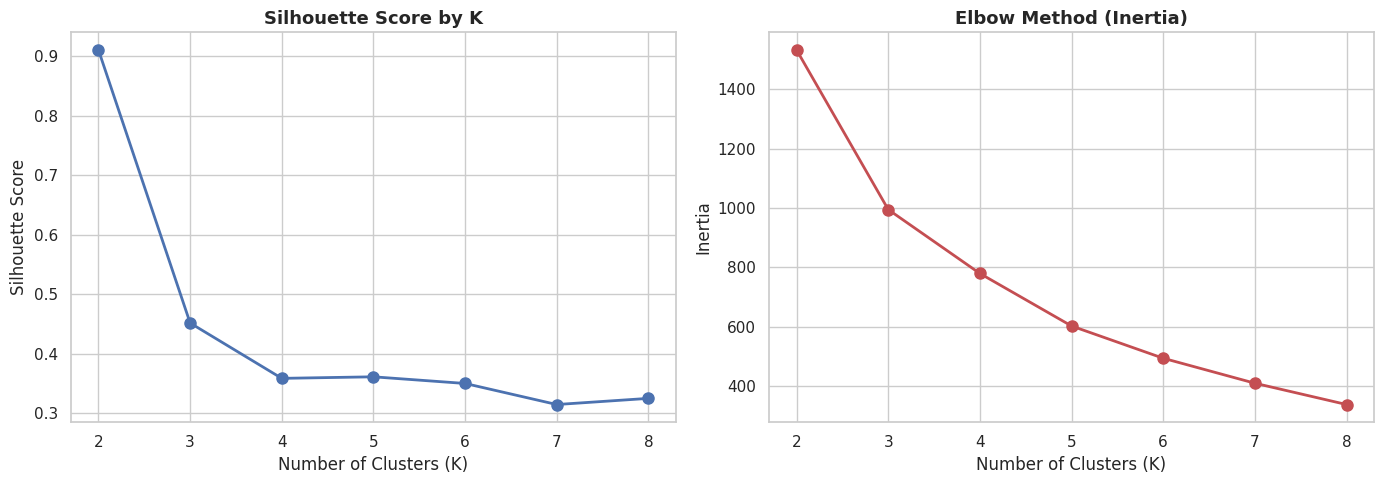

Saved: cluster_selection.png

Best K by silhouette: 2


In [11]:
# --- Determine optimal K using silhouette score ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_data)

k_range = range(2, 9)
silhouette_scores = []
inertias = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    silhouette_scores.append(sil)
    inertias.append(kmeans.inertia_)
    print(f"  K={k}: Silhouette={sil:.4f}, Inertia={kmeans.inertia_:,.0f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(list(k_range), silhouette_scores, 'bo-', linewidth=2, markersize=8)
ax1.set_title('Silhouette Score by K', fontsize=13, fontweight='bold')
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Silhouette Score')
ax1.set_xticks(list(k_range))

ax2.plot(list(k_range), inertias, 'ro-', linewidth=2, markersize=8)
ax2.set_title('Elbow Method (Inertia)', fontsize=13, fontweight='bold')
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Inertia')
ax2.set_xticks(list(k_range))

plt.tight_layout()
plt.savefig('cluster_selection.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: cluster_selection.png")

best_k = list(k_range)[np.argmax(silhouette_scores)]
print(f"\nBest K by silhouette: {best_k}")

In [12]:
# --- Run final K-Means with 4 clusters ---
# Using K=4 to create actionable groups (adjustable based on silhouette results above)
# 4 repeat-customer segments + 1 single-order segment = 5 total groups
OPTIMAL_K = 4

# Re-fit scaler and model for the chosen K
scaler_final = StandardScaler()
X_final = scaler_final.fit_transform(cluster_data)
kmeans_final = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=20)
repeat_valid['Cluster_Raw'] = kmeans_final.fit_predict(X_final)

# Compute cluster centers in original scale
centers = pd.DataFrame(
    scaler_final.inverse_transform(kmeans_final.cluster_centers_),
    columns=features
)
centers['Cluster_Raw'] = range(OPTIMAL_K)

# Sort clusters by Monthly_Revenue to assign meaningful names
centers = centers.sort_values('Monthly_Revenue', ascending=False).reset_index(drop=True)
rank_map = dict(zip(centers['Cluster_Raw'], range(OPTIMAL_K)))
repeat_valid['Cluster_Rank'] = repeat_valid['Cluster_Raw'].map(rank_map)

# Assign business-friendly segment names
segment_names = {
    0: 'A - High Velocity',
    1: 'B - Steady Performers',
    2: 'C - Moderate Movers',
    3: 'D - Low & Slow'
}
repeat_valid['Segment'] = repeat_valid['Cluster_Rank'].map(segment_names)

# Assign single-order customers to segment E
single_customers['Segment'] = 'E - New / One-Time'
single_customers['Cluster_Rank'] = 4

print(f"Silhouette score (K={OPTIMAL_K}): {silhouette_score(X_final, kmeans_final.labels_):.4f}")
print(f"\nCluster centers (original scale):")
centers_display = centers.copy()
centers_display['Segment'] = centers_display.index.map(segment_names)
print(centers_display[['Segment', 'Monthly_Revenue', 'Avg_Days_Between_Orders', 'Avg_Order_Value']].to_string(index=False))

Silhouette score (K=4): 0.3588

Cluster centers (original scale):
              Segment  Monthly_Revenue  Avg_Days_Between_Orders  Avg_Order_Value
    A - High Velocity         9,239.73                     7.44         5,744.36
B - Steady Performers           711.14                    61.76         1,346.41
  C - Moderate Movers           316.82                   172.15         1,358.03
       D - Low & Slow           282.61                    60.77           685.08


In [13]:
# --- Combine all customers into final segmented dataset ---
all_customers = pd.concat([
    repeat_valid,
    single_customers
], ignore_index=True)

# For single-order customers, estimate velocity from their one order
# Conservative: assume they sell through at a slower rate
all_customers.loc[all_customers['Segment'] == 'E - New / One-Time', 'Daily_Hat_Velocity'] = (
    all_customers.loc[all_customers['Segment'] == 'E - New / One-Time', 'Total_Hats_Ordered'] /
    all_customers.loc[all_customers['Segment'] == 'E - New / One-Time', 'Account_Age_Days'].clip(lower=30)
)
all_customers.loc[all_customers['Segment'] == 'E - New / One-Time', 'Days_To_50pct'] = (
    HALF_DISPLAY_HATS / all_customers.loc[all_customers['Segment'] == 'E - New / One-Time', 'Daily_Hat_Velocity']
)

print(f"\n{'='*70}")
print(f"CUSTOMER SEGMENTATION RESULTS")
print(f"{'='*70}")
print(f"\nTotal customers segmented: {len(all_customers):,}")
print(f"\nSegment Breakdown:")
seg_summary = all_customers.groupby('Segment').agg(
    Count=('Customer', 'count'),
    Pct=('Customer', 'count'),
    Avg_Net_Revenue=('Net_Revenue', 'mean'),
    Total_Net_Revenue=('Net_Revenue', 'sum'),
    Avg_Orders=('Num_Orders', 'mean'),
    Avg_Monthly_Rev=('Monthly_Revenue', 'mean'),
    Avg_Days_Between=('Avg_Days_Between_Orders', 'mean'),
    Avg_Daily_Hats=('Daily_Hat_Velocity', 'mean'),
    Avg_Days_to_50pct=('Days_To_50pct', 'mean')
).reset_index()
seg_summary['Pct'] = (seg_summary['Count'] / seg_summary['Count'].sum() * 100).round(1)
seg_summary['Revenue_Share'] = (seg_summary['Total_Net_Revenue'] / seg_summary['Total_Net_Revenue'].sum() * 100).round(1)

print(seg_summary.to_string(index=False))


CUSTOMER SEGMENTATION RESULTS

Total customers segmented: 1,041

Segment Breakdown:
              Segment  Count   Pct  Avg_Net_Revenue  Total_Net_Revenue  Avg_Orders  Avg_Monthly_Rev  Avg_Days_Between  Avg_Daily_Hats  Avg_Days_to_50pct  Revenue_Share
    A - High Velocity      2  0.20        19,117.00          38,234.00       34.50         9,239.73              7.44           45.09               3.08           1.50
B - Steady Performers    190 18.30         4,861.27         923,641.88        4.09           712.72             61.65            3.21              59.12          35.50
  C - Moderate Movers    133 12.80         2,588.83         344,313.90        2.11           317.42            172.61            0.71             212.03          13.20
       D - Low & Slow    389 37.40         2,253.41         876,578.05        3.81           282.83             60.96            2.13             124.85          33.70
   E - New / One-Time    327 31.40         1,281.75         419,132.75     

---
## 6. Segment Deep-Dive & Visualization

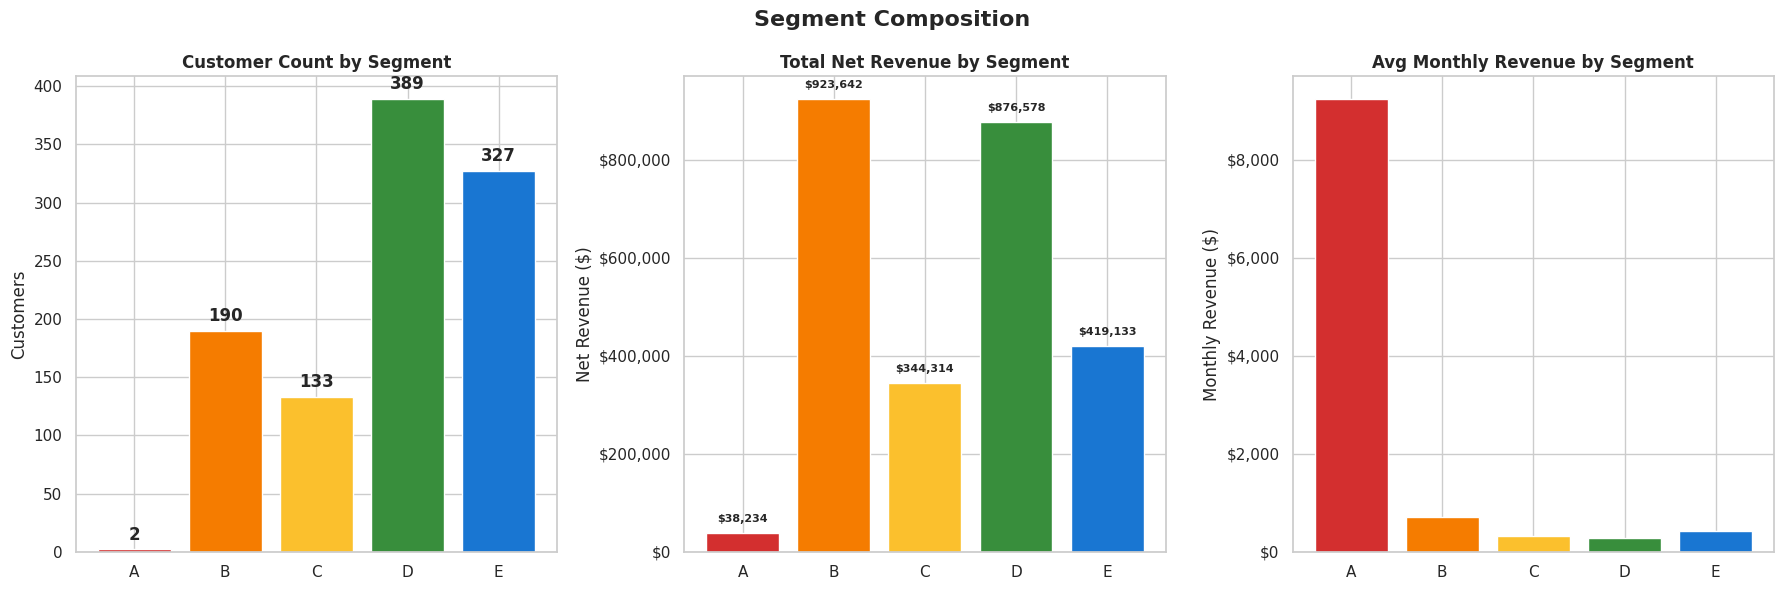

Saved: segment_composition.png


In [14]:
# --- Segment composition bar charts ---
seg_colors = {
    'A - High Velocity': '#D32F2F',
    'B - Steady Performers': '#F57C00',
    'C - Moderate Movers': '#FBC02D',
    'D - Low & Slow': '#388E3C',
    'E - New / One-Time': '#1976D2'
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Segment Composition', fontsize=16, fontweight='bold')

# Customer count by segment
ax = axes[0]
seg_counts = all_customers['Segment'].value_counts().sort_index()
bars = ax.bar(range(len(seg_counts)), seg_counts.values, 
              color=[seg_colors[s] for s in seg_counts.index], edgecolor='white')
ax.set_xticks(range(len(seg_counts)))
ax.set_xticklabels([s.split(' - ')[0] for s in seg_counts.index], fontsize=11)
ax.set_title('Customer Count by Segment', fontweight='bold')
ax.set_ylabel('Customers')
for bar, val in zip(bars, seg_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, str(val),
            ha='center', va='bottom', fontweight='bold')

# Revenue share by segment
ax = axes[1]
seg_rev = all_customers.groupby('Segment')['Net_Revenue'].sum().sort_index()
bars = ax.bar(range(len(seg_rev)), seg_rev.values,
              color=[seg_colors[s] for s in seg_rev.index], edgecolor='white')
ax.set_xticks(range(len(seg_rev)))
ax.set_xticklabels([s.split(' - ')[0] for s in seg_rev.index], fontsize=11)
ax.set_title('Total Net Revenue by Segment', fontweight='bold')
ax.set_ylabel('Net Revenue ($)')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'${x:,.0f}'))
for bar, val in zip(bars, seg_rev.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + seg_rev.max()*0.02,
            f'${val:,.0f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# Average monthly revenue by segment
ax = axes[2]
seg_monthly = all_customers.groupby('Segment')['Monthly_Revenue'].mean().sort_index()
bars = ax.bar(range(len(seg_monthly)), seg_monthly.values,
              color=[seg_colors[s] for s in seg_monthly.index], edgecolor='white')
ax.set_xticks(range(len(seg_monthly)))
ax.set_xticklabels([s.split(' - ')[0] for s in seg_monthly.index], fontsize=11)
ax.set_title('Avg Monthly Revenue by Segment', fontweight='bold')
ax.set_ylabel('Monthly Revenue ($)')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.tight_layout()
plt.savefig('segment_composition.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: segment_composition.png")

In [15]:
# --- Interactive 3D scatter of segments ---
repeat_plot = repeat_valid.copy()

fig = px.scatter_3d(
    repeat_plot,
    x='Avg_Days_Between_Orders',
    y='Avg_Order_Value',
    z='Monthly_Revenue',
    color='Segment',
    color_discrete_map=seg_colors,
    hover_name='Customer',
    hover_data={
        'Primary_Rep': True,
        'Net_Revenue': ':$,.0f',
        'Num_Orders': True,
        'Avg_Days_Between_Orders': ':.0f',
        'Daily_Hat_Velocity': ':.2f'
    },
    title='Customer Segments: 3D View (Frequency x Order Size x Monthly Revenue)',
    labels={
        'Avg_Days_Between_Orders': 'Avg Days Between Orders',
        'Avg_Order_Value': 'Avg Order Value ($)',
        'Monthly_Revenue': 'Monthly Revenue ($)'
    },
    opacity=0.8,
    height=700
)
fig.update_layout(template='plotly_white')
fig.show()

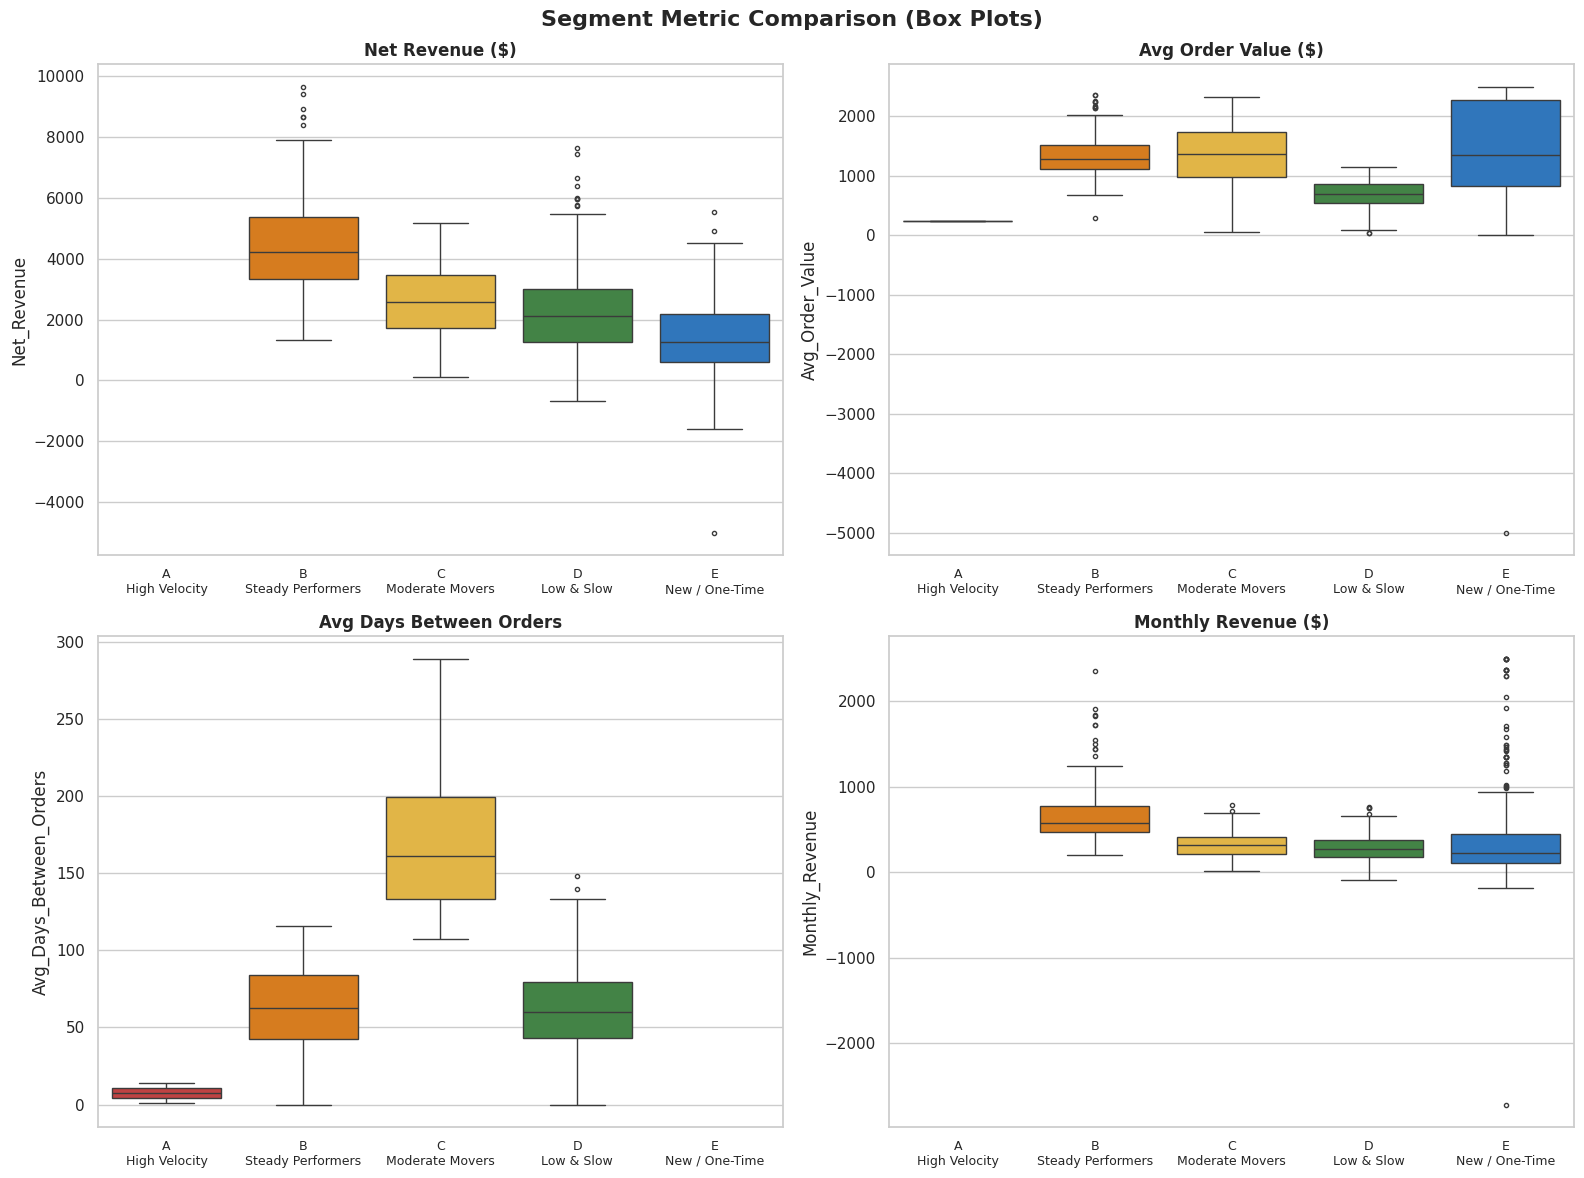

Saved: segment_boxplots.png


In [16]:
# --- Box plots comparing segments on key metrics ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Segment Metric Comparison (Box Plots)', fontsize=16, fontweight='bold')

segment_order = sorted(all_customers['Segment'].unique())
palette = [seg_colors[s] for s in segment_order]

metrics = [
    ('Net_Revenue', 'Net Revenue ($)', True),
    ('Avg_Order_Value', 'Avg Order Value ($)', True),
    ('Avg_Days_Between_Orders', 'Avg Days Between Orders', False),
    ('Monthly_Revenue', 'Monthly Revenue ($)', True)
]

for idx, (col, label, clip_outliers) in enumerate(metrics):
    ax = axes[idx // 2][idx % 2]
    plot_data = all_customers[['Segment', col]].dropna()
    if clip_outliers:
        q99 = plot_data[col].quantile(0.99)
        plot_data = plot_data[plot_data[col] <= q99]
    sns.boxplot(data=plot_data, x='Segment', y=col, order=segment_order,
                palette=seg_colors, ax=ax, fliersize=3)
    ax.set_title(label, fontweight='bold')
    ax.set_xlabel('')
    ax.set_xticklabels([s.split(' - ')[0] + '\n' + s.split(' - ')[1] for s in segment_order], fontsize=9)

plt.tight_layout()
plt.savefig('segment_boxplots.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: segment_boxplots.png")

---
## 7. Reorder Timing & Display Depletion Model

### Key Logic
- Each reorder a customer places tells us they **sold enough hats** to need restocking
- **Sell-through rate** = average hats per order / average days between orders
- **Days to 50% display** = 104 hats / daily sell-through rate
- **Recommended visit** = visit BEFORE the display hits 50% (with a safety buffer)

In [17]:
# --- Calculate recommended visit intervals per segment ---
# Safety buffer: visit when display is projected to be at ~60% (not waiting until 50%)
SAFETY_BUFFER_PCT = 0.60  # Visit when display reaches 60% full (125 hats remaining)
BUFFER_HATS = int(FULL_DISPLAY_HATS * (1 - SAFETY_BUFFER_PCT))  # Hats sold before visit = 83
CRITICAL_HATS = HALF_DISPLAY_HATS  # 104 hats sold = 50% depletion

# For repeat customers: use their actual velocity
repeat_with_velocity = all_customers[all_customers['Daily_Hat_Velocity'].notna() & (all_customers['Daily_Hat_Velocity'] > 0)].copy()

# Recommended visit interval = days until 60% remaining (40% sold)
repeat_with_velocity['Recommended_Visit_Days'] = (BUFFER_HATS / repeat_with_velocity['Daily_Hat_Velocity']).round(0)
# Hard deadline = days until 50% remaining
repeat_with_velocity['Hard_Deadline_Days'] = (CRITICAL_HATS / repeat_with_velocity['Daily_Hat_Velocity']).round(0)

print(f"Customers with calculable velocity: {len(repeat_with_velocity):,}")
print(f"\nVisit timing by segment:")
visit_timing = repeat_with_velocity.groupby('Segment').agg(
    Count=('Customer', 'count'),
    Avg_Daily_Hats=('Daily_Hat_Velocity', 'mean'),
    Median_Daily_Hats=('Daily_Hat_Velocity', 'median'),
    Avg_Recommended_Visit=('Recommended_Visit_Days', 'mean'),
    Median_Recommended_Visit=('Recommended_Visit_Days', 'median'),
    Avg_Hard_Deadline=('Hard_Deadline_Days', 'mean'),
    Median_Hard_Deadline=('Hard_Deadline_Days', 'median')
).round(1)
print(visit_timing.to_string())

Customers with calculable velocity: 1,026

Visit timing by segment:
                       Count  Avg_Daily_Hats  Median_Daily_Hats  Avg_Recommended_Visit  Median_Recommended_Visit  Avg_Hard_Deadline  Median_Hard_Deadline
Segment                                                                                                                                                  
A - High Velocity          2           45.10              45.10                   2.50                      2.50               3.50                  3.50
B - Steady Performers    186            3.20               1.70                  47.20                     48.00              59.10                 60.00
C - Moderate Movers      133            0.70               0.70                 169.20                    120.00             212.10                151.00
D - Low & Slow           380            2.10               1.00                  99.60                     87.00             124.80                109.00
E - New 

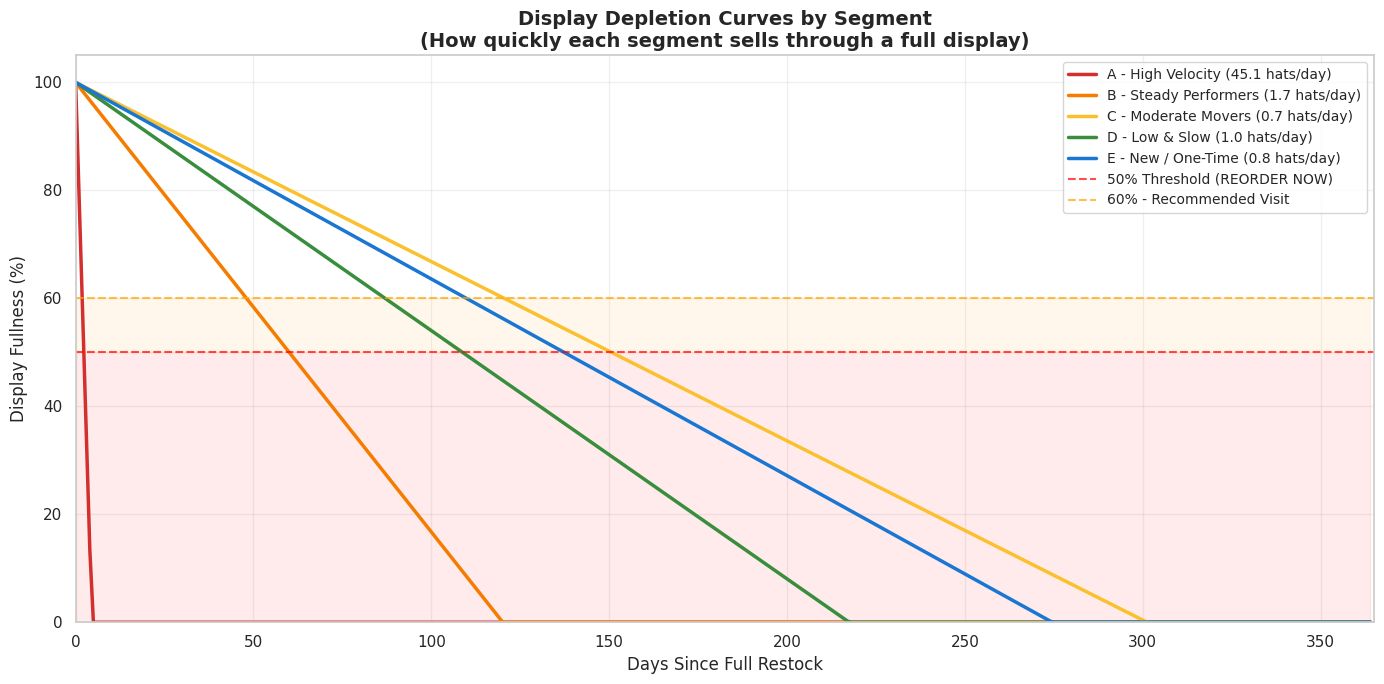

Saved: depletion_curves.png


In [18]:
# --- Display depletion curves by segment ---
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title('Display Depletion Curves by Segment\n(How quickly each segment sells through a full display)',
             fontsize=14, fontweight='bold')

days_range = np.arange(0, 365)

for segment in sorted(repeat_with_velocity['Segment'].unique()):
    seg_data = repeat_with_velocity[repeat_with_velocity['Segment'] == segment]
    avg_velocity = seg_data['Daily_Hat_Velocity'].median()
    hats_remaining = np.maximum(FULL_DISPLAY_HATS - avg_velocity * days_range, 0)
    pct_remaining = hats_remaining / FULL_DISPLAY_HATS * 100
    ax.plot(days_range, pct_remaining, linewidth=2.5, label=f"{segment} ({avg_velocity:.1f} hats/day)",
            color=seg_colors.get(segment, '#999'))

# Reference lines
ax.axhline(y=50, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='50% Threshold (REORDER NOW)')
ax.axhline(y=60, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='60% - Recommended Visit')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

ax.set_xlabel('Days Since Full Restock', fontsize=12)
ax.set_ylabel('Display Fullness (%)', fontsize=12)
ax.set_xlim(0, 365)
ax.set_ylim(0, 105)
ax.legend(loc='upper right', fontsize=10)
ax.fill_between(days_range, 0, 50, alpha=0.08, color='red')
ax.fill_between(days_range, 50, 60, alpha=0.08, color='orange')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('depletion_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: depletion_curves.png")

---
## 8. Visit Schedule Recommendations

In [19]:
# --- Build final recommendation table ---
# Merge visit timing back into the full customer set
visit_cols = ['Customer', 'Recommended_Visit_Days', 'Hard_Deadline_Days']
all_customers = all_customers.merge(
    repeat_with_velocity[visit_cols], on='Customer', how='left',
    suffixes=('', '_calc')
)

# For single-order customers: assign conservative defaults based on segment E averages
# or use their estimated velocity if available
single_mask = all_customers['Segment'] == 'E - New / One-Time'
has_velocity = all_customers['Daily_Hat_Velocity'].notna() & (all_customers['Daily_Hat_Velocity'] > 0)
all_customers.loc[single_mask & has_velocity, 'Recommended_Visit_Days'] = (
    BUFFER_HATS / all_customers.loc[single_mask & has_velocity, 'Daily_Hat_Velocity']
).round(0)
all_customers.loc[single_mask & has_velocity, 'Hard_Deadline_Days'] = (
    CRITICAL_HATS / all_customers.loc[single_mask & has_velocity, 'Daily_Hat_Velocity']
).round(0)

# Calculate next recommended visit date
all_customers['Next_Visit_Date'] = all_customers.apply(
    lambda r: r['Last_Order_Date'] + timedelta(days=r['Recommended_Visit_Days'])
    if pd.notna(r['Recommended_Visit_Days']) and pd.notna(r['Last_Order_Date'])
    else pd.NaT, axis=1
)

# Flag urgency
all_customers['Days_Until_Visit'] = (all_customers['Next_Visit_Date'] - DATA_END_DATE).dt.days
all_customers['Urgency'] = pd.cut(
    all_customers['Days_Until_Visit'],
    bins=[-np.inf, 0, 14, 30, 60, np.inf],
    labels=['OVERDUE', 'Urgent (< 2 weeks)', 'Soon (2-4 weeks)', 'Upcoming (1-2 months)', 'On Track']
)

print(f"{'='*70}")
print(f"VISIT SCHEDULE SUMMARY")
print(f"{'='*70}")
print(f"\nUrgency Breakdown (as of {DATA_END_DATE.strftime('%Y-%m-%d')}):")
urgency_counts = all_customers['Urgency'].value_counts()
for urgency, count in urgency_counts.items():
    print(f"  {urgency}: {count} customers")

VISIT SCHEDULE SUMMARY

Urgency Breakdown (as of 2026-02-06):
  OVERDUE: 479 customers
  On Track: 220 customers
  Upcoming (1-2 months): 119 customers
  Urgent (< 2 weeks): 118 customers
  Soon (2-4 weeks): 90 customers


In [20]:
# --- Segment visit strategy summary ---
print(f"{'='*70}")
print(f"RECOMMENDED VISIT STRATEGY BY SEGMENT")
print(f"{'='*70}\n")

strategy = repeat_with_velocity.groupby('Segment').agg(
    Customers=('Customer', 'count'),
    Revenue_Share_Pct=('Net_Revenue', lambda x: x.sum()),
    Median_Visit_Days=('Recommended_Visit_Days', 'median'),
    Median_Deadline_Days=('Hard_Deadline_Days', 'median'),
    Avg_Daily_Hats=('Daily_Hat_Velocity', 'median'),
    Avg_Order_Size=('Avg_Order_Value', 'median')
).reset_index()

total_rev = strategy['Revenue_Share_Pct'].sum()
strategy['Revenue_Share_Pct'] = (strategy['Revenue_Share_Pct'] / total_rev * 100).round(1)

for _, row in strategy.iterrows():
    segment = row['Segment']
    print(f"--- {segment} ---")
    print(f"  Customers:           {int(row['Customers'])}")
    print(f"  Revenue share:       {row['Revenue_Share_Pct']:.1f}%")
    print(f"  Sell-through rate:   {row['Avg_Daily_Hats']:.1f} hats/day")
    print(f"  Median order size:   ${row['Avg_Order_Size']:,.0f}")
    print(f"  Recommended visit:   Every {int(row['Median_Visit_Days'])} days")
    print(f"  Hard deadline:       {int(row['Median_Deadline_Days'])} days (50% depleted)")
    
    visits_per_year = 365 / row['Median_Visit_Days'] if row['Median_Visit_Days'] > 0 else 0
    print(f"  Visits per year:     ~{visits_per_year:.1f}")
    print()

RECOMMENDED VISIT STRATEGY BY SEGMENT

--- A - High Velocity ---
  Customers:           2
  Revenue share:       1.5%
  Sell-through rate:   45.1 hats/day
  Median order size:   $5,744
  Recommended visit:   Every 2 days
  Hard deadline:       3 days (50% depleted)
  Visits per year:     ~146.0

--- B - Steady Performers ---
  Customers:           186
  Revenue share:       35.2%
  Sell-through rate:   1.7 hats/day
  Median order size:   $1,273
  Recommended visit:   Every 48 days
  Hard deadline:       60 days (50% depleted)
  Visits per year:     ~7.6

--- C - Moderate Movers ---
  Customers:           133
  Revenue share:       13.3%
  Sell-through rate:   0.7 hats/day
  Median order size:   $1,362
  Recommended visit:   Every 120 days
  Hard deadline:       151 days (50% depleted)
  Visits per year:     ~3.0

--- D - Low & Slow ---
  Customers:           380
  Revenue share:       33.6%
  Sell-through rate:   1.0 hats/day
  Median order size:   $696
  Recommended visit:   Every 87 

In [21]:
# --- Overdue and urgent customers detail ---
urgent_customers = all_customers[
    all_customers['Urgency'].isin(['OVERDUE', 'Urgent (< 2 weeks)'])
].sort_values('Days_Until_Visit').copy()

print(f"{'='*70}")
print(f"CUSTOMERS NEEDING IMMEDIATE ATTENTION ({len(urgent_customers)} total)")
print(f"{'='*70}\n")

urgent_display = urgent_customers[[
    'Customer', 'Segment', 'Primary_Rep', 'Net_Revenue', 'Num_Orders',
    'Days_Since_Last_Order', 'Recommended_Visit_Days',
    'Days_Until_Visit', 'Urgency'
]].head(40)

urgent_display

CUSTOMERS NEEDING IMMEDIATE ATTENTION (597 total)



,Customer,Segment,Primary_Rep,Net_Revenue,Num_Orders,Days_Since_Last_Order,Recommended_Visit_Days,Days_Until_Visit,Urgency
255,Grocery Outlet - Blue Diamond,B - Steady Performers,Unassigned,"4,721.60",2,269,8.00,-261.00,OVERDUE
723,Ace Hardware-Jerome,E - New / One-Time,Bobbi Marshall,"3,247.50",1,296,69.00,-227.00,OVERDUE
299,Grocery Outlet - LaQuinta,B - Steady Performers,Unassigned,"3,813.60",3,214,5.00,-209.00,OVERDUE
290,Grocery Outlet - Grand Terrace,D - Low & Slow,Unassigned,"2,360.80",3,214,13.00,-201.00,OVERDUE
264,Grocery Outlet - City Heights,D - Low & Slow,Unassigned,"2,088.40",3,214,14.00,-200.00,OVERDUE
300,Grocery Outlet - Lacey,B - Steady Performers,Unassigned,"2,281.35",2,227,28.00,-199.00,OVERDUE
38,BJ’S Food Mart,D - Low & Slow,Unassigned,"1,824.00",2,231,32.00,-199.00,OVERDUE
893,Grocery Outlet - Truckee,E - New / One-Time,Unassigned,"5,538.80",1,240,43.00,-197.00,OVERDUE
216,Good2Go #414,D - Low & Slow,Unassigned,493.50,2,235,38.00,-197.00,OVERDUE
198,Good2Go #102,D - Low & Slow,Unassigned,"1,135.50",2,198,5.00,-193.00,OVERDUE


In [22]:
# --- Visit urgency visualization ---
# Treemap requires positive values; filter to customers with positive Net_Revenue
treemap_data = all_customers[
    all_customers['Urgency'].notna() & (all_customers['Net_Revenue'] > 0)
].copy()

fig = px.treemap(
    treemap_data,
    path=['Urgency', 'Segment', 'Primary_Rep'],
    values='Net_Revenue',
    color='Urgency',
    color_discrete_map={
        'OVERDUE': '#D32F2F',
        'Urgent (< 2 weeks)': '#F57C00',
        'Soon (2-4 weeks)': '#FBC02D',
        'Upcoming (1-2 months)': '#81C784',
        'On Track': '#388E3C'
    },
    title='Visit Urgency Treemap (Size = Net Revenue)',
    height=600
)
fig.update_traces(textinfo='label+value+percent parent')
fig.show()

---
## 9. Rep Workload & Territory Analysis

In [23]:
# --- Rep-level summary ---
rep_summary = all_customers.groupby('Primary_Rep').agg(
    Total_Customers=('Customer', 'count'),
    Total_Net_Revenue=('Net_Revenue', 'sum'),
    Avg_Customer_Revenue=('Net_Revenue', 'mean'),
    High_Velocity=('Segment', lambda x: (x == 'A - High Velocity').sum()),
    Steady=('Segment', lambda x: (x == 'B - Steady Performers').sum()),
    Moderate=('Segment', lambda x: (x == 'C - Moderate Movers').sum()),
    Low_Slow=('Segment', lambda x: (x == 'D - Low & Slow').sum()),
    New_OneTime=('Segment', lambda x: (x == 'E - New / One-Time').sum()),
    Overdue=('Urgency', lambda x: (x == 'OVERDUE').sum()),
    Urgent=('Urgency', lambda x: (x == 'Urgent (< 2 weeks)').sum())
).sort_values('Total_Net_Revenue', ascending=False).reset_index()

# Estimate annual visits needed per rep
def est_annual_visits(row):
    # Based on median visit frequency per segment
    seg_visit_freq = strategy.set_index('Segment')['Median_Visit_Days'].to_dict()
    visits = 0
    for seg, freq in seg_visit_freq.items():
        n_customers = (all_customers[
            (all_customers['Primary_Rep'] == row['Primary_Rep']) & 
            (all_customers['Segment'] == seg)
        ].shape[0])
        if freq > 0:
            visits += n_customers * (365 / freq)
    # Add 2 visits/year for single-order customers
    visits += row['New_OneTime'] * 2
    return round(visits)

rep_summary['Est_Annual_Visits'] = rep_summary.apply(est_annual_visits, axis=1)
rep_summary['Est_Monthly_Visits'] = (rep_summary['Est_Annual_Visits'] / 12).round(1)

print("REP WORKLOAD SUMMARY")
print("="*90)
rep_summary[['Primary_Rep', 'Total_Customers', 'Total_Net_Revenue', 'High_Velocity', 'Steady',
             'Moderate', 'Low_Slow', 'New_OneTime', 'Overdue', 'Urgent',
             'Est_Annual_Visits', 'Est_Monthly_Visits']]

REP WORKLOAD SUMMARY


,Primary_Rep,Total_Customers,Total_Net_Revenue,High_Velocity,Steady,Moderate,Low_Slow,New_OneTime,Overdue,Urgent,Est_Annual_Visits,Est_Monthly_Visits
0,Unassigned,669,"1,739,552.95",1,143,81,238,206,317,73,3574,297.80
1,Lamar Helm,60,"226,866.50",0,17,9,23,11,30,9,312,26.00
2,Andy Coon,46,"96,250.50",0,6,6,21,13,16,5,221,18.40
3,Ann Wheelock,32,"81,921.00",0,2,3,20,7,20,2,145,12.10
4,Bobbi Marshall,32,"68,509.00",0,4,5,15,8,10,2,151,12.60
5,Jason Black,21,"54,166.50",0,3,3,10,5,14,2,100,8.30
6,VIEGEAR,21,"53,578.43",1,3,0,5,12,9,3,254,21.20
7,JADEN BLACK,33,"40,401.00",0,3,4,10,16,16,2,162,13.50
8,Merlin Gleed,21,"39,597.00",0,1,3,9,8,11,1,97,8.10
9,Eric Arnold,15,"39,118.20",0,3,3,2,7,3,3,78,6.50


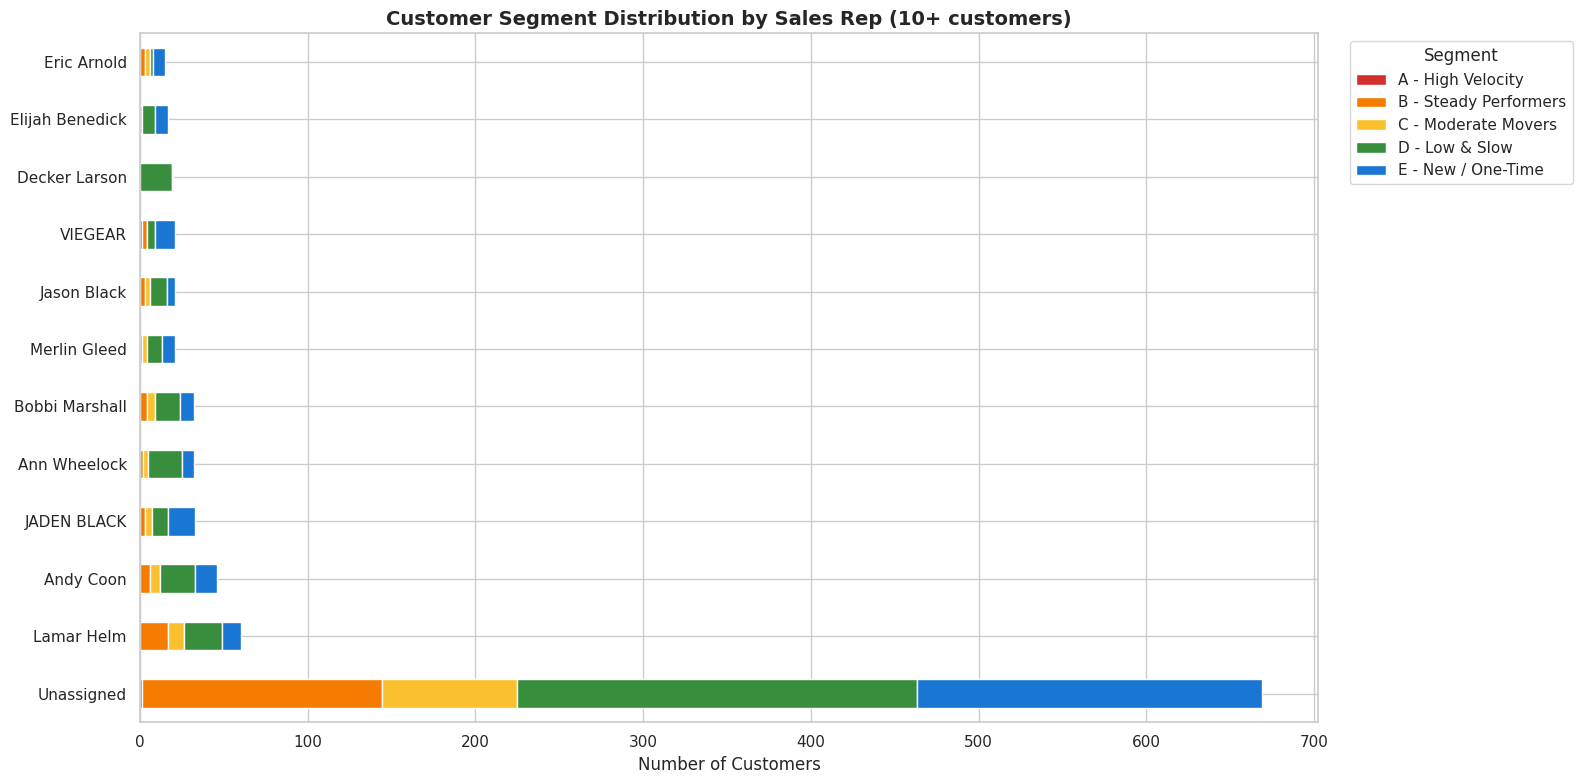

Saved: rep_segment_distribution.png


In [24]:
# --- Rep segment distribution stacked bar ---
rep_seg = all_customers.groupby(['Primary_Rep', 'Segment']).size().unstack(fill_value=0)
# Filter to reps with 10+ customers
top_reps = rep_summary[rep_summary['Total_Customers'] >= 10]['Primary_Rep'].tolist()
rep_seg_filtered = rep_seg.loc[rep_seg.index.isin(top_reps)].copy()
rep_seg_filtered = rep_seg_filtered.loc[rep_seg_filtered.sum(axis=1).sort_values(ascending=False).index]

fig, ax = plt.subplots(figsize=(16, 8))
rep_seg_filtered.plot(kind='barh', stacked=True, ax=ax,
                       color=[seg_colors.get(s, '#999') for s in rep_seg_filtered.columns],
                       edgecolor='white')
ax.set_title('Customer Segment Distribution by Sales Rep (10+ customers)', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Customers')
ax.set_ylabel('')
ax.legend(title='Segment', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.savefig('rep_segment_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: rep_segment_distribution.png")

---
## 10. Seasonal Analysis & Monthly Trends

In [25]:
# --- Monthly sales trends by segment ---
invoices_with_seg = invoice_summary.merge(
    all_customers[['Customer', 'Segment']], on='Customer', how='left'
)
invoices_with_seg['Month'] = invoices_with_seg['Date'].dt.to_period('M')

monthly_by_seg = invoices_with_seg.groupby(['Month', 'Segment']).agg(
    Revenue=('Invoice_Revenue', 'sum'),
    Orders=('Document_Number', 'nunique'),
    Hats=('Est_Hats', 'sum')
).reset_index()
monthly_by_seg['Month_dt'] = monthly_by_seg['Month'].dt.to_timestamp()

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.08,
                    subplot_titles=('Monthly Revenue by Segment', 'Monthly Orders by Segment'))

for segment in sorted(monthly_by_seg['Segment'].dropna().unique()):
    seg_data = monthly_by_seg[monthly_by_seg['Segment'] == segment]
    fig.add_trace(go.Scatter(
        x=seg_data['Month_dt'], y=seg_data['Revenue'],
        name=segment, mode='lines+markers',
        line=dict(color=seg_colors.get(segment, '#999'), width=2),
        legendgroup=segment
    ), row=1, col=1)
    fig.add_trace(go.Scatter(
        x=seg_data['Month_dt'], y=seg_data['Orders'],
        name=segment, mode='lines+markers', showlegend=False,
        line=dict(color=seg_colors.get(segment, '#999'), width=2),
        legendgroup=segment
    ), row=2, col=1)

fig.update_yaxes(title_text='Revenue ($)', row=1, col=1)
fig.update_yaxes(title_text='Order Count', row=2, col=1)
fig.update_layout(height=700, template='plotly_white',
                  title='Monthly Sales Trends by Customer Segment')
fig.show()

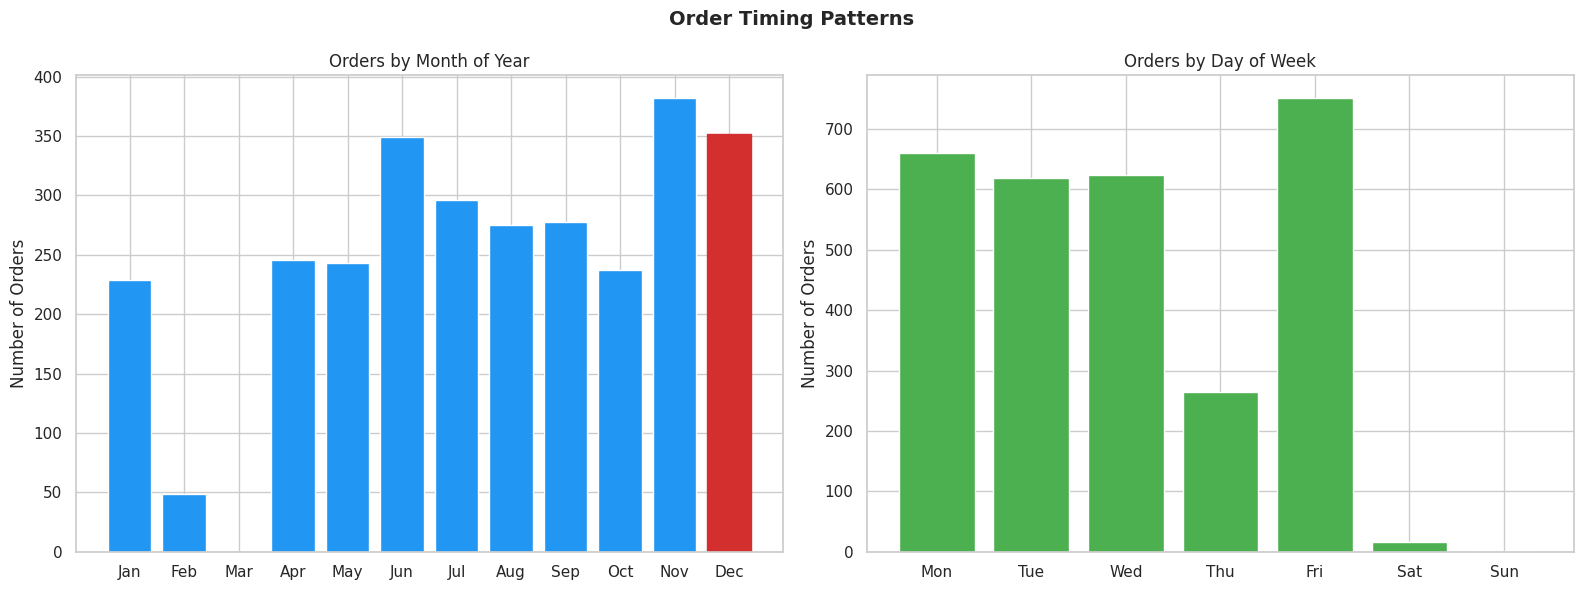

Saved: order_timing_patterns.png


In [26]:
# --- Day-of-week and month-of-year ordering patterns ---
invoices_with_seg['DayOfWeek'] = invoices_with_seg['Date'].dt.day_name()
invoices_with_seg['MonthName'] = invoices_with_seg['Date'].dt.month_name()
invoices_with_seg['MonthNum'] = invoices_with_seg['Date'].dt.month

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Order Timing Patterns', fontsize=14, fontweight='bold')

# Orders by month
ax = axes[0]
monthly_orders = invoices_with_seg.groupby('MonthNum')['Document_Number'].nunique()
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
bars = ax.bar(monthly_orders.index, monthly_orders.values, color='#2196F3', edgecolor='white')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_labels)
ax.set_title('Orders by Month of Year')
ax.set_ylabel('Number of Orders')

# Highlight peak months
peak_month = monthly_orders.idxmax()
bars[peak_month - 1].set_color('#D32F2F')

# Orders by day of week
ax = axes[1]
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_orders = invoices_with_seg.groupby('DayOfWeek')['Document_Number'].nunique().reindex(day_order)
ax.bar(range(7), daily_orders.values, color='#4CAF50', edgecolor='white')
ax.set_xticks(range(7))
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax.set_title('Orders by Day of Week')
ax.set_ylabel('Number of Orders')

plt.tight_layout()
plt.savefig('order_timing_patterns.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: order_timing_patterns.png")

---
## 11. Interactive Customer Lookup Tool

In [27]:
# --- Interactive customer lookup ---
def customer_report(customer_name):
    """Generate a detailed report for a specific customer."""
    matches = all_customers[all_customers['Customer'].str.contains(customer_name, case=False, na=False)]
    
    if len(matches) == 0:
        print(f"No customers found matching '{customer_name}'")
        return
    
    if len(matches) > 1:
        print(f"Multiple matches found for '{customer_name}':")
        for _, row in matches.iterrows():
            print(f"  - {row['Customer']} ({row['Segment']})")
        print("\nShowing first match:\n")
    
    c = matches.iloc[0]
    print(f"{'='*60}")
    print(f"CUSTOMER REPORT: {c['Customer']}")
    print(f"{'='*60}")
    print(f"\n  Segment:             {c['Segment']}")
    print(f"  Sales Rep:           {c['Primary_Rep']}")
    print(f"  Net Revenue:         ${c['Net_Revenue']:,.2f}")
    print(f"  Total Orders:        {int(c['Num_Orders'])}")
    print(f"  Avg Order Value:     ${c['Avg_Order_Value']:,.2f}")
    print(f"  Total Hats Ordered:  {int(c['Total_Hats_Ordered'])}")
    print(f"  Avg Hats/Order:      {c['Avg_Hats_Per_Order']:.0f}")
    print(f"  First Order:         {c['First_Order_Date'].strftime('%Y-%m-%d') if pd.notna(c['First_Order_Date']) else 'N/A'}")
    print(f"  Last Order:          {c['Last_Order_Date'].strftime('%Y-%m-%d') if pd.notna(c['Last_Order_Date']) else 'N/A'}")
    print(f"  Days Since Last:     {int(c['Days_Since_Last_Order'])}")
    
    if pd.notna(c.get('Avg_Days_Between_Orders')):
        print(f"\n  --- Velocity Metrics ---")
        print(f"  Avg Days Between Orders: {c['Avg_Days_Between_Orders']:.0f}")
        print(f"  Daily Hat Velocity:      {c['Daily_Hat_Velocity']:.2f} hats/day")
        print(f"  Monthly Revenue Rate:    ${c['Monthly_Revenue']:,.2f}")
    
    if pd.notna(c.get('Recommended_Visit_Days')):
        print(f"\n  --- Visit Recommendation ---")
        print(f"  Visit every:        {int(c['Recommended_Visit_Days'])} days")
        print(f"  Hard deadline:      {int(c['Hard_Deadline_Days'])} days (50% depleted)")
        if pd.notna(c.get('Next_Visit_Date')):
            print(f"  Next visit by:      {c['Next_Visit_Date'].strftime('%Y-%m-%d')}")
            print(f"  Urgency:            {c['Urgency']}")
    
    # Show order history
    cust_invoices = invoice_summary[invoice_summary['Customer'] == c['Customer']].sort_values('Date')
    if len(cust_invoices) > 0:
        print(f"\n  --- Order History ---")
        for _, inv in cust_invoices.iterrows():
            print(f"  {inv['Date'].strftime('%Y-%m-%d')}  {inv['Document_Number']:>12}  "
                  f"${inv['Invoice_Revenue']:>8,.2f}  ({int(inv['Est_Hats'])} hats, {int(inv['Line_Items'])} styles)")

# Example lookups
customer_report("Mike's Market-Garden City")
print("\n")
customer_report("Benedict's Market")

CUSTOMER REPORT: Mike's Market-Garden City

  Segment:             B - Steady Performers
  Sales Rep:           Unassigned
  Net Revenue:         $23,854.50
  Total Orders:        29
  Avg Order Value:     $833.79
  Total Hats Ordered:  2035
  Avg Hats/Order:      70
  First Order:         2025-04-03
  Last Order:          2026-01-22
  Days Since Last:     15

  --- Velocity Metrics ---
  Avg Days Between Orders: 10
  Daily Hat Velocity:      6.68 hats/day
  Monthly Revenue Rate:    $2,349.94

  --- Visit Recommendation ---
  Visit every:        12 days
  Hard deadline:      16 days (50% depleted)
  Next visit by:      2026-02-03
  Urgency:            OVERDUE

  --- Order History ---
  2025-04-03     INV000037  $  756.00  (64 hats, 9 styles)
  2025-04-09     INV000094  $2,436.00  (205 hats, 9 styles)
  2025-04-09     INV000106  $11,256.00  (948 hats, 26 styles)
  2025-04-28     INV000236  $  288.00  (24 hats, 3 styles)
  2025-06-09     INV000551  $  480.00  (40 hats, 5 styles)
  2025-0

In [28]:
# --- Search any customer (modify the name below) ---
# Uncomment and change the name to look up any customer:
# customer_report("Town Pump")
# customer_report("Broulim")
# customer_report("Hoback")

# List all customers in a specific segment:
def list_segment(segment_letter):
    """List all customers in a segment (A, B, C, D, or E)."""
    seg_mask = all_customers['Segment'].str.startswith(segment_letter)
    seg_df = all_customers[seg_mask].sort_values('Net_Revenue', ascending=False)
    print(f"\n{'='*60}")
    print(f"SEGMENT {segment_letter} CUSTOMERS ({len(seg_df)} total)")
    print(f"{'='*60}")
    display_cols = ['Customer', 'Primary_Rep', 'Net_Revenue', 'Num_Orders',
                    'Avg_Order_Value', 'Monthly_Revenue', 'Days_Since_Last_Order']
    return seg_df[display_cols]

# Show Segment A (High Velocity)
list_segment('A')


SEGMENT A CUSTOMERS (2 total)


,Customer,Primary_Rep,Net_Revenue,Num_Orders,Avg_Order_Value,Monthly_Revenue,Days_Since_Last_Order
577,Templeton Feed and Grain,VIEGEAR,"22,508.00",2,"11,254.00","10,226.02",53
604,Town Pump (Employee Orders),Unassigned,"15,726.00",67,234.72,"8,253.44",0


---
## 12. Export Segmented Data

In [29]:
# --- Export the complete segmented customer list ---
export_cols = [
    'Customer', 'Segment', 'Primary_Rep',
    'Net_Revenue', 'Total_Invoice_Revenue', 'Total_Credits',
    'Num_Orders', 'Avg_Order_Value', 'Median_Order_Value',
    'Total_Hats_Ordered', 'Avg_Hats_Per_Order',
    'First_Order_Date', 'Last_Order_Date',
    'Days_Since_Last_Order', 'Account_Age_Days',
    'Avg_Days_Between_Orders', 'Monthly_Revenue', 'Monthly_Hats',
    'Daily_Hat_Velocity', 'Days_To_50pct',
    'Recommended_Visit_Days', 'Hard_Deadline_Days',
    'Next_Visit_Date', 'Urgency'
]

# Only include columns that exist
export_cols = [c for c in export_cols if c in all_customers.columns]

export_df = all_customers[export_cols].sort_values(['Segment', 'Net_Revenue'], ascending=[True, False])

# Save to CSV
export_df.to_csv('customer_segments_with_visit_schedule.csv', index=False)
print(f"Exported {len(export_df):,} customers to: customer_segments_with_visit_schedule.csv")

# Also create a concise action list for reps
action_list = all_customers[
    all_customers['Urgency'].isin(['OVERDUE', 'Urgent (< 2 weeks)', 'Soon (2-4 weeks)'])
].sort_values(['Primary_Rep', 'Days_Until_Visit']).copy()

action_cols = ['Customer', 'Segment', 'Primary_Rep', 'Net_Revenue',
               'Days_Since_Last_Order', 'Recommended_Visit_Days', 'Urgency']
action_cols = [c for c in action_cols if c in action_list.columns]

action_list[action_cols].to_csv('visit_action_list.csv', index=False)
print(f"Exported {len(action_list):,} customers needing visits to: visit_action_list.csv")

Exported 1,041 customers to: customer_segments_with_visit_schedule.csv
Exported 687 customers needing visits to: visit_action_list.csv


In [30]:
# --- Final summary statistics ---
print(f"{'='*70}")
print(f"ARCADIAN OUTFITTERS - CUSTOMER SEGMENTATION SUMMARY")
print(f"{'='*70}")
print(f"\nData period: {invoices['Date'].min().strftime('%Y-%m-%d')} to {invoices['Date'].max().strftime('%Y-%m-%d')}")
print(f"Total customers analyzed: {len(all_customers):,}")
print(f"Total net revenue: ${all_customers['Net_Revenue'].sum():,.2f}")
print(f"Total hats ordered: {all_customers['Total_Hats_Ordered'].sum():,.0f}")
print(f"\n{'='*70}")
print(f"SEGMENT DEFINITIONS & VISIT GUIDELINES")
print(f"{'='*70}")
print(f"""
A - HIGH VELOCITY
  These stores move product fast. They are your top revenue drivers and
  need the most frequent attention. Plan visits on a tight cycle to
  prevent stockouts that cost you and the retailer sales.

B - STEADY PERFORMERS  
  Reliable reorder accounts with consistent purchasing patterns.
  They sell steadily and reorder at predictable intervals. Schedule
  visits just ahead of their typical reorder cycle.

C - MODERATE MOVERS
  Decent accounts that sell through at a moderate pace. These stores
  don't need frequent visits but should not be neglected. Space visits
  appropriately to catch them before the display gets too low.

D - LOW & SLOW
  Slower-moving accounts. They reorder infrequently and in smaller
  amounts. Visit these strategically - group them into geographic
  routes to minimize travel cost per visit.

E - NEW / ONE-TIME
  Customers with only one order on record. They may be genuinely new
  accounts that need nurturing, or they may be one-time purchases.
  Prioritize a check-in visit to assess display health and encourage
  a reorder. The first reorder converts them into a repeat customer.
""")

print(f"Files generated:")
print(f"  - customer_segments_with_visit_schedule.csv  (full segmented data)")
print(f"  - visit_action_list.csv                      (urgent visits needed)")
print(f"  - customer_distributions.png                 (distribution charts)")
print(f"  - cluster_selection.png                      (K selection analysis)")
print(f"  - segment_composition.png                    (segment breakdown)")
print(f"  - segment_boxplots.png                       (metric comparisons)")
print(f"  - depletion_curves.png                       (display depletion model)")
print(f"  - rep_segment_distribution.png               (rep workload analysis)")
print(f"  - order_timing_patterns.png                  (seasonal patterns)")

ARCADIAN OUTFITTERS - CUSTOMER SEGMENTATION SUMMARY

Data period: 2025-04-02 to 2026-02-06
Total customers analyzed: 1,041
Total net revenue: $2,601,900.58
Total hats ordered: 241,326

SEGMENT DEFINITIONS & VISIT GUIDELINES

A - HIGH VELOCITY
  These stores move product fast. They are your top revenue drivers and
  need the most frequent attention. Plan visits on a tight cycle to
  prevent stockouts that cost you and the retailer sales.

B - STEADY PERFORMERS  
  Reliable reorder accounts with consistent purchasing patterns.
  They sell steadily and reorder at predictable intervals. Schedule
  visits just ahead of their typical reorder cycle.

C - MODERATE MOVERS
  Decent accounts that sell through at a moderate pace. These stores
  don't need frequent visits but should not be neglected. Space visits
  appropriately to catch them before the display gets too low.

D - LOW & SLOW
  Slower-moving accounts. They reorder infrequently and in smaller
  amounts. Visit these strategically - gro